# Advanced Modeling Features 

In this tutorial we will explore some advanced modeling features of epydemix. In particular, we will:

- Define a new transition kind (behavioral)
- Explore time-varying and age-varying parameters
- Explore the use of shorter time steps and resampling
- Explore the use of different initial conditions

Let's start by importing the necessary libraries.

In [5]:
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles
import numpy as np

## 1. Define a new transition kind (behavioral)

New transition kinds can be defined by passing a custom function to the `register_transition_kind` method of the `EpiModel` class. This function takes as input the name of the new transition kind and the function that computes the transition probability for that kind.

For example, we can define a new transition kind called "behavioral" that takes into account the behavior of the population. We will consider the model presented in [Perra et al. (2011)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0023084), where a new behavioral compartment is introduced to account for the fact that individuals can change their behavior over time and that, as result, get infected with a lower probability. More in detail, we will consider the case in which susceptible individuals can transitiom to the behavioral compartment following the rate:

$$r_{S \to S^B} = \beta_B (1 - e^{-\gamma I})$$

where $\beta_B$ and $\gamma$ regulates the behavioral response. We can see that this rate is not a simple mass-action rate, therefore we need to define a new transition kind. For clarity, here we report the scheme of the model:

We need to define the function that computes the transition probability for the new transition kind. This function must take as input the transition rate (string or list of strings), the transition parameters (a dictionary), and the current state of the system (a dictionary).

In [6]:
def compute_behavioral_transition_probability(rate, params, system_data): 
    """
    Compute the probability of a behavioral transition.

    Args:
        rate: The rate of the transition
        params: The parameters of the transition. params["agent"] is the agent compartment
        system_data: A dictionary containing information about the current state of the system.
            - parameters: The model parameters. This is a dictionary of arrays, where the key is the name of the parameter and the value is a 
                          2D array of shape (n_time_steps, n_groups). The first dimension is the time step, the second is the demographic group.
            - t: The current time step
            - comp_indices: The indices of the compartments. This is a dictionary where the key is the name of the compartment and the 
                            value is the index of the compartment in the system.
            - contact_matrix: The contact matrix
            - pop: The population in different compartments. This is a 2D array of shape (n_compartments, n_groups). The first dimension is 
                   the compartment, the second is the demographic group.
            - pop_sizes: The population sizes. This is a 1D array of shape (n_groups,).
            - dt: The time step size
    """
    beta_B, gamma = system_data["parameters"][rate[0]][system_data["t"]], system_data["parameters"][rate[1]][system_data["t"]]
    agent_idx = system_data["comp_indices"][params["agent"]]
    interaction = beta_B * (1 - np.exp(-gamma * np.sum(system_data["pop"][agent_idx])))
    return 1 - np.exp(-interaction * system_data["dt"])


Next, we create the model and register the new transition kind.

In [7]:
model = EpiModel(compartments=["S", "SB", "I", "R"], 
                 parameters={"beta": 0.3, 
                             "mu": 0.1, 
                             "r": 0.3,
                             "beta_B": 0.05, 
                             "gamma": 1. / 10000.})

model.register_transition_kind(kind="behavioral", function=compute_behavioral_transition_probability)

model.add_transition(source="S", target="I", rate="beta", params={"agent": "I"}, kind="mediated")
model.add_transition(source="SB", target="I", rate="r*beta", params={"agent": "I"}, kind="mediated")
model.add_transition(source="S", target="SB", rate=["beta_B", "gamma"], params={"agent": "I"}, kind="behavioral")
model.add_transition(source="I", target="R", rate="mu", kind="spontaneous")

We simulate the model and plot the evolution of individuals in the different compartments.

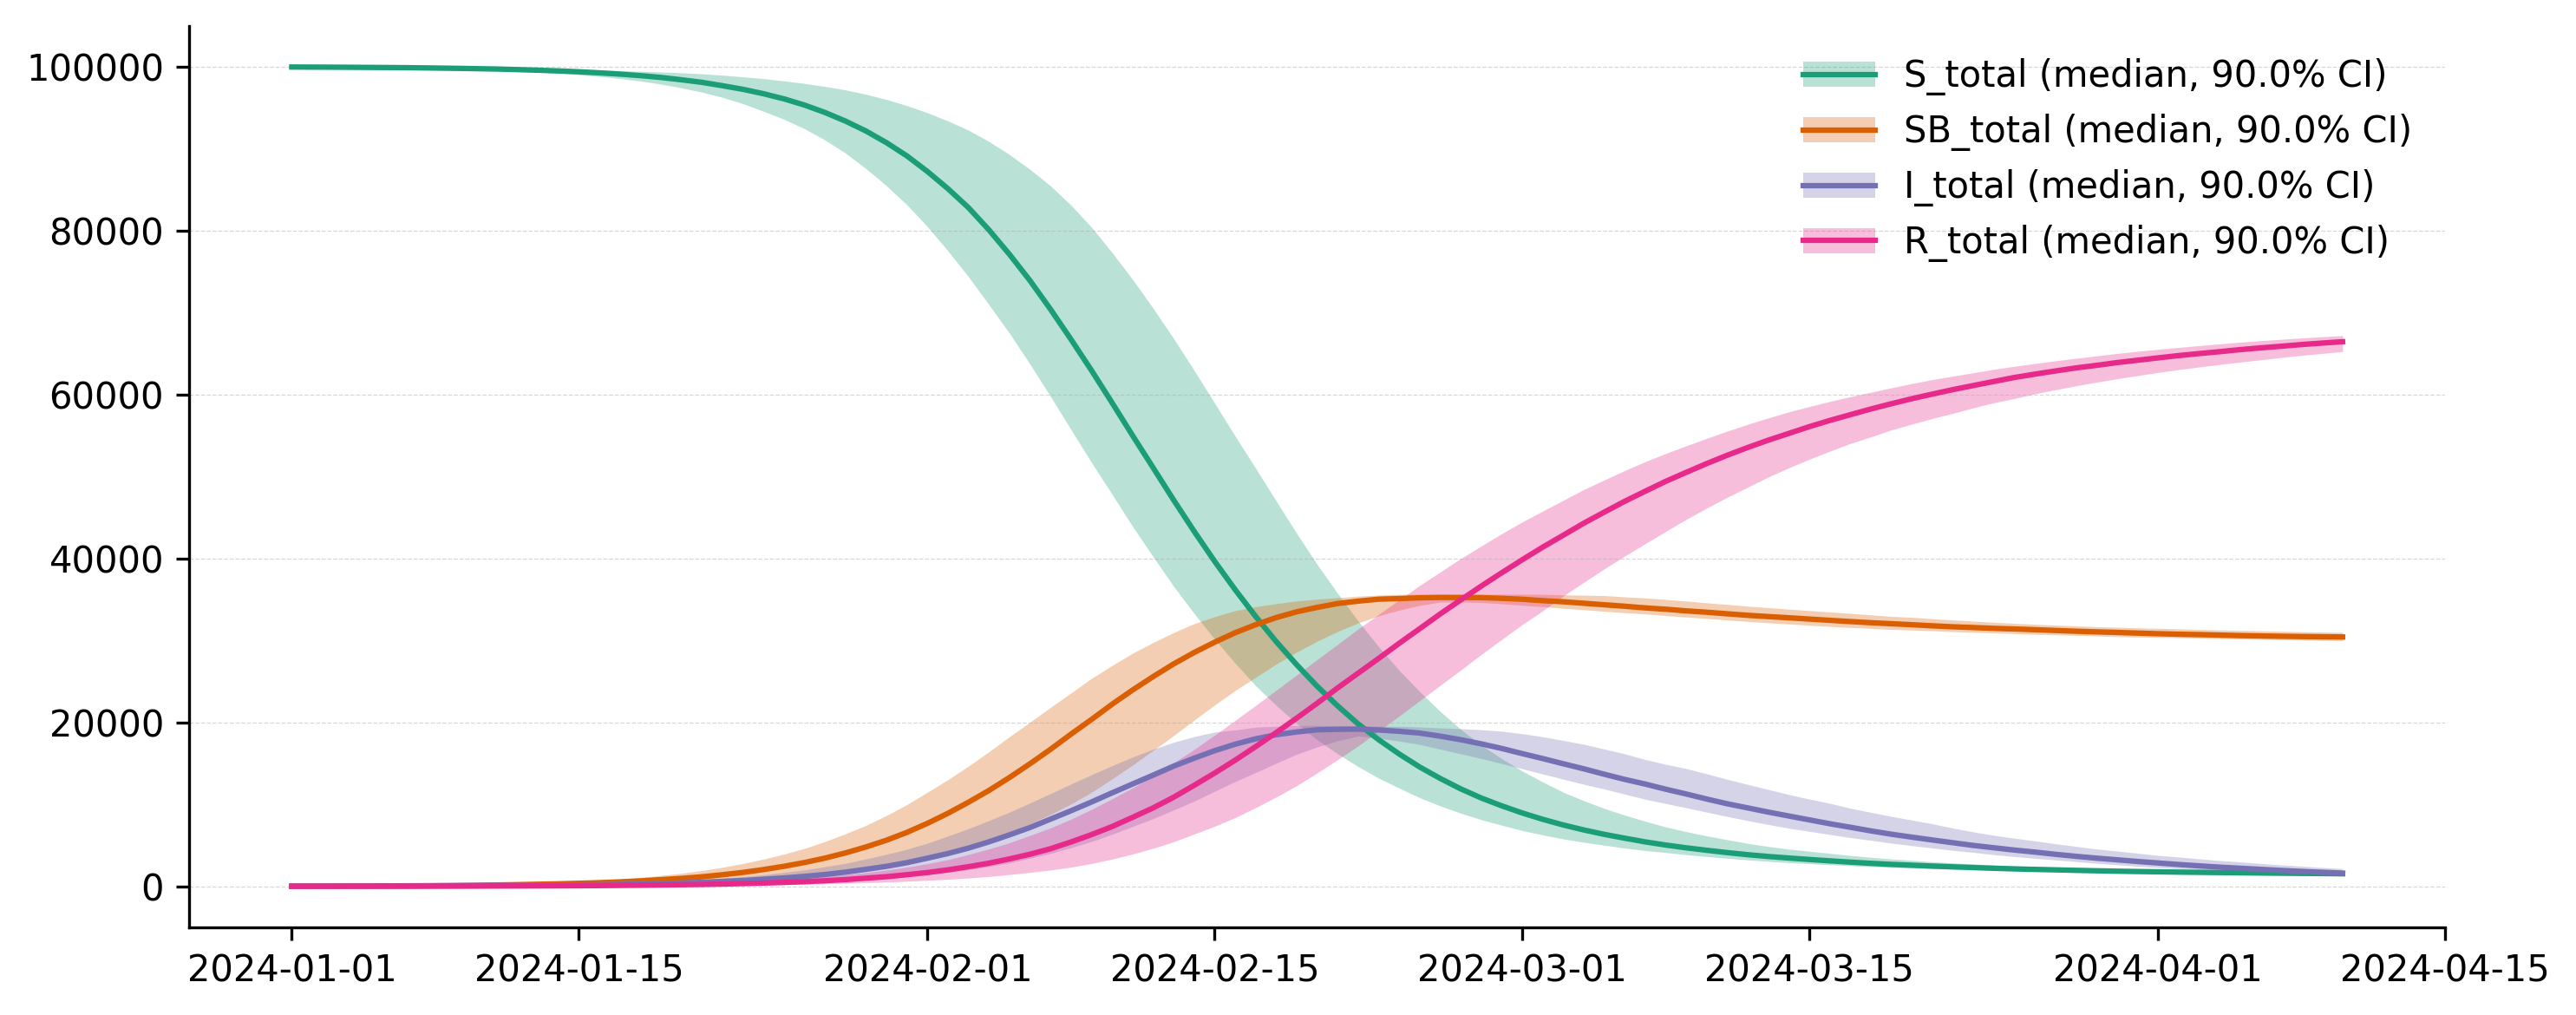

In [8]:
# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'SB': 0,   
    'I': 10,   
    'R': 0     
}

# running the simulations
results = model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10",
    initial_conditions_dict=initial_conditions
)

# plot
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["S_total", "SB_total", "I_total", "R_total"], legend_loc="upper right");